### Introduction
This notebook is the first step towards creating an algorithm that predicts the probability of train cancellation. Here I am going to analyze the open source dataset about train services that I found, performing data preprocessing and data cleaning based on constraints and requirements that I am going to describe below

#### Constraints
The features that would be used to train the model have to follow at least one of the following criteria:
a) The information stored in the feature is a part of the user's input
Example: The user's input is a city of destination, a city of departure and departure time for their future trip.
b) It is possible to retrieve or calculate the information stored in the feature based on the user's input. 
Example: The user (normally) doesn't know about maintenance works, but it is possible to search for any maintenance on the specified route, using the time and the stations that the user provided

#### (Functional) Requirements

1. The model has to give an estimate on total delay that the user might face, including arrival delay
2. The model has to give an estimate on the train's cancellation 
3. The estimation should be given in a form of a percentage
4. The model has to predict the delay probability for every 5-minute batch (example: 10% chance of 5 minute delay, 15% chance of 10 minute delay)
5. The model must be able to solve a multi-label classification problem, as there would be multiple features in y_test

At this point you should have all of the neccessary information to understand the logic behind my future steps. Let's start the data preprocessing!


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from pathlib import Path  
from tqdm import tqdm

2023-12-21 07:42:37.662122: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 07:42:38.300046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 07:42:39.240612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-12-21 07:42:41.143385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 07:42:41.538018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 07:42:41.538059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


#### Brief dataset overview
The dataset that I found contains all of the neccessary information about train journeys in the Netherlands, including station code, station name, train id, train type and so on. However from the spot I can say that the amount of features is too big - I would certainly have to get rid of some of them, for example feature called Stop:RDT-id is just autoincremented and would have little to no impact on models prediction.
Moreover, though there's some NaN values that 'beg' to be cleaned, I certainly should put more effort into data cleaning than just typing df.dropna()

You can see the dataset overview below:

In [3]:
basic_info = pd.read_csv('services-2022.csv')
basic_info.head()

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled
0,7914217,2022-01-01,Intercity,NS,1410,False,False,4,71044085,RTD,Rotterdam Centraal,NaN,NaN,NaN,2022-01-01T02:00:00+01:00,4.0,False
1,7914217,2022-01-01,Intercity,NS,1410,False,False,0,71044086,DT,Delft,2022-01-01T02:13:00+01:00,3.0,False,2022-01-01T02:13:00+01:00,4.0,False
2,7914217,2022-01-01,Intercity,NS,1410,False,False,0,71044087,GV,Den Haag HS,2022-01-01T02:21:00+01:00,2.0,False,2022-01-01T02:23:00+01:00,1.0,False
3,7914217,2022-01-01,Intercity,NS,1410,False,False,0,71044088,LEDN,Leiden Centraal,2022-01-01T02:36:00+01:00,0.0,False,2022-01-01T02:45:00+01:00,0.0,False
4,7914217,2022-01-01,Intercity,NS,1410,False,False,0,71044089,SHL,Schiphol Airport,2022-01-01T03:01:00+01:00,0.0,False,2022-01-01T03:03:00+01:00,0.0,False


In [4]:
#Selecting only the first million and 200 thousand rows to make the processing much faster
basic_info = basic_info.head(3000000)
len(basic_info)

3000000

#### Update 3 (20.12.2023): 
#### The problem with NaN values on arrival delay

After starting on classification research, I found out that there's only 1,7% of journeys with train cancellations. After looking for ways to increase this number, I've realized that I remove a lot of cancelled journeys just because the Departure cancelled value is NaN

Now on one hand it makes perfect sense, since Departure cancelled is a feature which I want to predict. But on the other hand, there's also some cases when the Departure Cancelled feature value is NaN, whilst the "Arrival Cancelled" feature value is "True", meaning that the train was cancelled on arrival, so the departure wasn't even planned. 

In [5]:
sorted_dataset = basic_info[(basic_info['Stop:Arrival cancelled'] == True) & (basic_info['Stop:Departure cancelled'].isna())]
sorted_dataset.head(50)
len(sorted_dataset)

23499

As you can see there's almost 210 thousand cases like this (!). Now not all of them are going to make it to the final version of the dataset due to other data cleaning steps, but still I am certain that it would be beneficial to not remove them from the dataset.

#### Дописать!!!!

#### First steps:

##### a) Rename columns in the dataset 
Currently the column's names in the dataset are too long and too complicated, which makes the data preprocessing part much harder, especially when dealing with specific columns names. So I've renamed the columns, making them more clear and concise

##### b) Data cleaning. Dropping features
Elaboration on dropping features:
Train id, Stop id: this features just indicate the id of the entry, not pointing to any potential correlations
Maximum delay, Arrival cancelled, Completely cancelled, Partly cancelled: Though this features could be of use, they do not follow the requirements - the user can't possibly know if train arrival was cancelled, and though it is possible to make the model compute this features by putting them into y_test, this would only make everything more complicated, so it is much easier just to remove this 4 features from the dataset.

##### c) Data cleaning. Dealing with NaN values. 
After performing a short analysis, I've decided to deal with null values in this way:
* For NaN values in y_test labels: Drop the entire entry
* For NaN values in y_train where type is float or int: Change value from NaN to 0
* For any NaN value which is of type "string" or "date": Drop the entire entry

In [6]:
column_list = basic_info.columns.tolist()

# Print the list of column names
print(column_list)

['Service:RDT-ID', 'Service:Date', 'Service:Type', 'Service:Company', 'Service:Train number', 'Service:Completely cancelled', 'Service:Partly cancelled', 'Service:Maximum delay', 'Stop:RDT-ID', 'Stop:Station code', 'Stop:Station name', 'Stop:Arrival time', 'Stop:Arrival delay', 'Stop:Arrival cancelled', 'Stop:Departure time', 'Stop:Departure delay', 'Stop:Departure cancelled']


In [7]:

    def data_cleaning_main_dataset(dataset):
        dataset.drop("Stop id", inplace = True, axis = 1)
        dataset['Stop id'] = dataset.groupby('Journey id').cumcount() + 1
        dataset.sort_values(by=['Journey id', 'Date'], inplace=True)
        dataset.drop("Partly cancelled", inplace = True, axis = 1)
        dataset.drop("Maximum delay", inplace = True, axis = 1)
        dataset.drop("Completely cancelled", inplace = True, axis = 1)
        dataset = dataset.dropna(axis=0, subset=['Departure delay'])
        #Update 3 starts
        mask = (dataset['Arrival cancelled'] == True) & (dataset['Departure cancelled'].isna())
        dataset.loc[mask, 'Departure cancelled'] = True
        #Update 3 ends
        dataset = dataset.dropna(subset=['Departure cancelled'])        
        dataset = dataset.dropna(axis=0, subset=['Departure time'])
        dataset['Arrival delay'] = dataset['Arrival delay'].fillna(0)
        dataset.drop("Arrival cancelled", inplace = True, axis = 1)
        return dataset

    def rename_columns_main_dataset(dataset):
        new_columns = {
        'Service:RDT-ID': 'Journey id',
        'Service:Date': 'Date',
        'Service:Type': 'Train type',
        'Service:Company': 'Railroad company',
        'Service:Train number': 'Train number',
        'Service:Completely cancelled': 'Completely cancelled',
        'Service:Partly cancelled': 'Partly cancelled',
        'Service:Maximum delay': 'Maximum delay',
        'Stop:RDT-ID': 'Stop id',
        'Stop:Station code': 'Station code',
        'Stop:Station name': 'Station name',
        'Stop:Arrival time': 'Arrival time',
        'Stop:Arrival delay': 'Arrival delay',
        'Stop:Arrival cancelled': 'Arrival cancelled',
        'Stop:Departure time': 'Departure time',
        'Stop:Departure delay': 'Departure delay',
        'Stop:Departure cancelled': 'Departure cancelled'
    }

        # Rename the columns
        dataset = dataset.rename(columns=new_columns)
        return dataset
        
        

#### Next step: 
Enriching the dataset with new features

I've decided to add two more features that would be obtained from "Date" column. This two features would be of boolean type and would be named "Is weekend" and "Is holiday".
The reason for adding this features is to extract as much information from the user's input as possible, as the information received from the user is qiute scarce - only 5 features. Moreover, it is important to add that dates contain more information than just plain numbers - for example according to open-source statistics, the total number of daily disruptions on weekends is almost 20% lower then on weekdays. 

In [8]:

def add_new_weekday_feature(dataset):
    new_weekday_feature = []
    for date_row in dataset['Date']:
        convert_to_date = datetime.strptime(date_row, '%Y-%m-%d')
        day_number = convert_to_date.weekday()
        if (day_number >= 5):
            new_weekday_feature.append(True)
        else:
            new_weekday_feature.append(False)
    dataset['Is_weekend'] = new_weekday_feature
    return dataset

def extract_holidays(dataset):
    list_with_holidays = [
    '2022-01-01',   # New Year's Day
    '2022-04-15',   # Good Friday
    '2022-04-17',   # Easter Sunday
    '2022-04-18',   # Easter Monday
    '2022-04-27',   # King's Day
    '2022-05-04',   # Remembrance Day
    '2022-05-05',   # Liberation Day
    '2022-05-26',   # Ascension Day
    '2022-06-05',   # Whit Sunday
    '2022-06-06',   # Whit Monday
    '2022-12-25',   # Christmas Day
    '2022-12-26',   # Second Christmas Day
    ]

    # Convert the 'Date' column to strings in the same format
    dataset['Date'] = pd.to_datetime(dataset['Date']).dt.strftime('%Y-%m-%d')
    # Create the 'Is_holiday' column based on the 'Date' column
    dataset['Is_holiday'] = dataset['Date'].isin(list_with_holidays)
    # Create the 'Is_holiday' column based on the 'Date' column
    return dataset
    
def data_preprocessing_main_dataset(dataset):
    dataset = add_new_weekday_feature(dataset)
    dataset = extract_holidays(dataset)
    return dataset


In [9]:
sorted_dataset = basic_info[basic_info['Service:Completely cancelled'] == True]
sorted_dataset.head(50)

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled
152,7914234,2022-01-01,Sprinter,NS,5110,True,True,0,71044240,RTD,Rotterdam Centraal,NaN,NaN,NaN,2022-01-01T05:36:00+01:00,0.0,True
153,7914234,2022-01-01,Sprinter,NS,5110,True,True,0,71044241,SDM,Schiedam Centrum,2022-01-01T05:41:00+01:00,0.0,True,2022-01-01T05:41:00+01:00,0.0,True
154,7914234,2022-01-01,Sprinter,NS,5110,True,True,0,71044242,DTCP,Delft Campus,2022-01-01T05:47:00+01:00,0.0,True,2022-01-01T05:47:00+01:00,0.0,True
155,7914234,2022-01-01,Sprinter,NS,5110,True,True,0,71044243,DT,Delft,2022-01-01T05:50:00+01:00,0.0,True,2022-01-01T05:50:00+01:00,0.0,True
156,7914234,2022-01-01,Sprinter,NS,5110,True,True,0,71044244,RSW,Rijswijk,2022-01-01T05:54:00+01:00,0.0,True,2022-01-01T05:54:00+01:00,0.0,True
157,7914234,2022-01-01,Sprinter,NS,5110,True,True,0,71044245,GVMW,Den Haag Moerwijk,2022-01-01T05:57:00+01:00,0.0,True,2022-01-01T05:57:00+01:00,0.0,True
158,7914234,2022-01-01,Sprinter,NS,5110,True,True,0,71044246,GV,Den Haag HS,2022-01-01T06:01:00+01:00,0.0,True,2022-01-01T06:03:00+01:00,0.0,True
159,7914234,2022-01-01,Sprinter,NS,5110,True,True,0,71044247,GVC,Den Haag Centraal,2022-01-01T06:06:00+01:00,0.0,True,NaN,NaN,NaN
1752,7914389,2022-01-01,Sprinter,NS,6622,True,True,0,71045895,DDR,Dordrecht,NaN,NaN,NaN,2022-01-01T07:28:00+01:00,0.0,True
1753,7914389,2022-01-01,Sprinter,NS,6622,True,True,0,71045896,DDZD,Dordrecht Zuid,2022-01-01T07:31:00+01:00,0.0,True,2022-01-01T07:31:00+01:00,0.0,True


In [10]:
print("Total rows before cleaning (main dataset): " + str(len(basic_info))) 

Total rows before cleaning (main dataset): 3000000


In [11]:
basic_info = rename_columns_main_dataset(basic_info)
basic_info = data_cleaning_main_dataset(basic_info)
basic_info = data_preprocessing_main_dataset(basic_info)
basic_info.head()

,Journey id,Date,Train type,Railroad company,Train number,Station code,Station name,Arrival time,Arrival delay,Departure time,Departure delay,Departure cancelled,Stop id,Is_weekend,Is_holiday
0,7914217,2022-01-01,Intercity,NS,1410,RTD,Rotterdam Centraal,NaN,0.0,2022-01-01T02:00:00+01:00,4.0,False,1,True,True
1,7914217,2022-01-01,Intercity,NS,1410,DT,Delft,2022-01-01T02:13:00+01:00,3.0,2022-01-01T02:13:00+01:00,4.0,False,2,True,True
2,7914217,2022-01-01,Intercity,NS,1410,GV,Den Haag HS,2022-01-01T02:21:00+01:00,2.0,2022-01-01T02:23:00+01:00,1.0,False,3,True,True
3,7914217,2022-01-01,Intercity,NS,1410,LEDN,Leiden Centraal,2022-01-01T02:36:00+01:00,0.0,2022-01-01T02:45:00+01:00,0.0,False,4,True,True
4,7914217,2022-01-01,Intercity,NS,1410,SHL,Schiphol Airport,2022-01-01T03:01:00+01:00,0.0,2022-01-01T03:03:00+01:00,0.0,False,5,True,True


#### Advanced data cleaning: Rare trains and small companies.
After observing the amount and distribution of unique values in "Train type" and "Railroad company" columns I've found out that there's a lot of small values in both features, that take around 0.01-0.05% of the dataset (see bar charts below for more information)
I've removed all entries from 'Train type' and 'Railroad company' columns where the distribution of the value within the feature is <1%. I believe that this would confuse the model much less, making the predictions more stable and precise.

In [12]:
def plot_bar_chart(label):
    grouped_data = basic_info.groupby(label).size()
    
    # Plot the bar chart
    grouped_data.plot(kind='bar', color='navajowhite', edgecolor='black')
    
    # Add labels and title
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.title('Distribution of ' + label)
    
    # Add percentages on top of each bar
    total_count = len(basic_info)  # Total number of entries in the DataFrame
    for i, value in enumerate(grouped_data):
        percentage = (value / total_count) * 100
        plt.text(i, value + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)
    
    # Show the plot
    plt.show()

In [13]:
print("Total rows after cleaning: " + str(len(basic_info))) 

Total rows after cleaning: 2686941


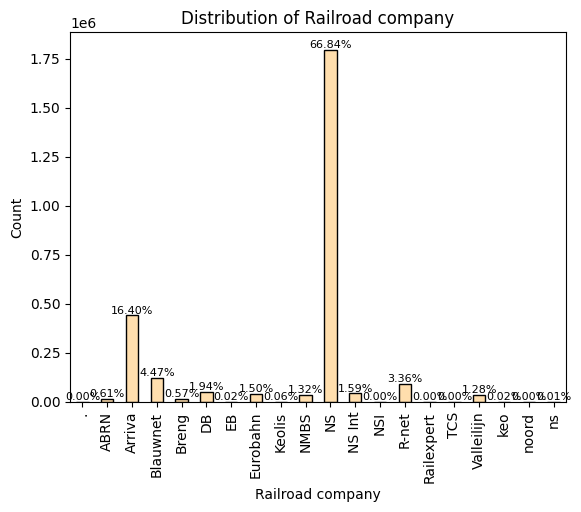

In [14]:
plot_bar_chart('Railroad company')

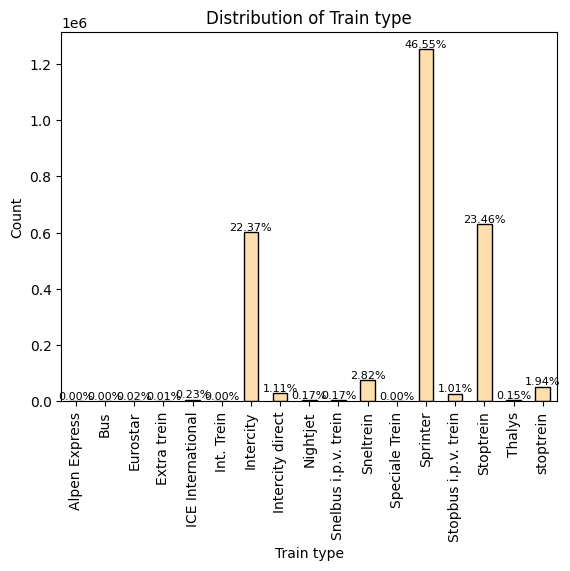

In [15]:
plot_bar_chart('Train type')

In [16]:
print(basic_info.groupby('Train type').size())

Train type
Alpen Express                27
Bus                          20
Eurostar                    518
Extra trein                 320
ICE International          6312
Int. Trein                   80
Intercity                601100
Intercity direct          29726
Nightjet                   4513
Snelbus i.p.v. trein       4471
Sneltrein                 75699
Speciale Trein               20
Sprinter                1250690
Stopbus i.p.v. trein      27161
Stoptrein                630292
Thalys                     3920
stoptrein                 52072
dtype: int64


In [17]:
print(basic_info["Railroad company"].unique())

['NS' 'NS Int' 'Arriva' 'ABRN' 'NMBS' 'Eurobahn' 'R-net' 'Blauwnet'
 'Valleilijn' 'DB' 'TCS' 'Breng' 'keo' '.' 'ns' 'Keolis' 'noord' 'EB'
 'NSI' 'Railexpert']


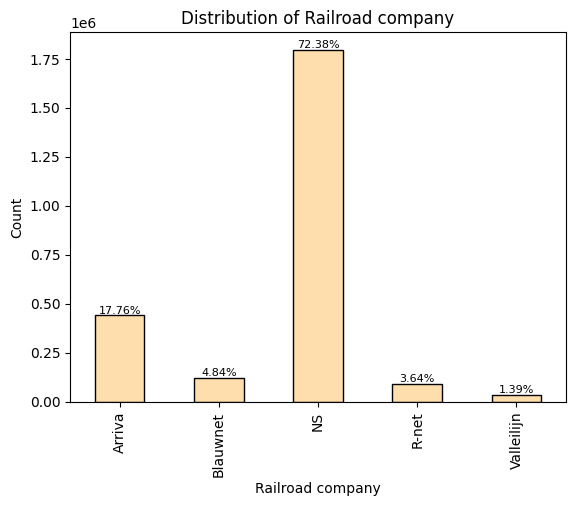

In [18]:
values_to_remove = ['NS Int', 'Eurobahn', 'Breng', 'DB', 'EB', 'NMBS', 'VIAS', 'ZLSM', 'keo', '.',
                   'ABRN', 'Keolis', 'NSI', 'Railexpert', 'TCS', 'connexxi', 'db', 'nmbs', 'noord']
basic_info['Railroad company'] = basic_info['Railroad company'].replace(values_to_remove, pd.NA)

# Drop rows with NaN values in 'Railroad company' column
basic_info = basic_info.dropna(subset=['Railroad company'])
basic_info['Railroad company'] = basic_info['Railroad company'].replace('ns', 'NS')
basic_info['Railroad company'] = basic_info['Railroad company'].replace('BN', 'Blauwnet')
basic_info['Railroad company'] = basic_info['Railroad company'].replace('Rnet', 'R-net')
plot_bar_chart('Railroad company')

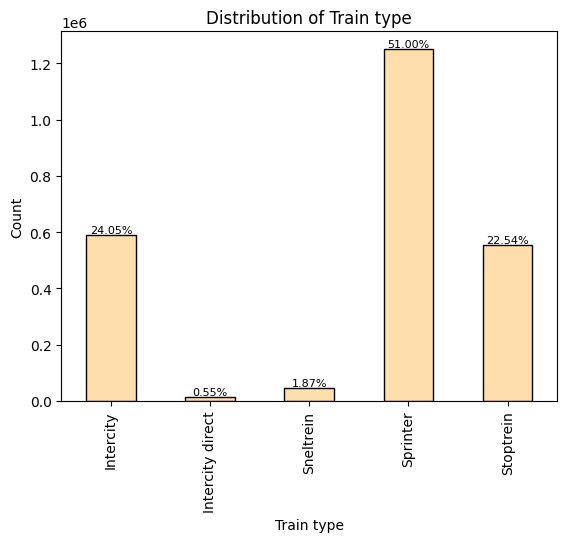

In [19]:
values_to_remove = ['Bus', 'Eurostar', 'Extra trein', 'ICE International', 'Int. Trein', 'Nachttrein', 'Nightjet',
                    'Snelbus i.p.v. trein', 'Stoomtrein', 'Thalys', 'Speciale Trein', 'Stopbus i.p.v. trein', 
                    'Metro i.p.v. trein', 'Dinnner Train', 'Alpen Express']
basic_info['Train type'] = basic_info['Train type'].replace(values_to_remove, pd.NA)
# Drop rows with NaN values in 'Railroad company' column
basic_info = basic_info.dropna(subset=['Train type'])
plot_bar_chart('Train type')

As you can see after I've removed all of the rarely occuring values, the train type and railroad company features are now much more structured and consistent

Below: Plotting features that still have null values in them. Removing null values from those features to ensure that the dataset is completely clean

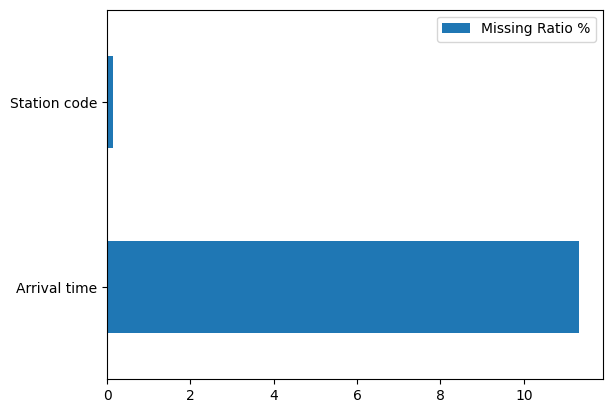

In [20]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(basic_info)

In [21]:
def fill_missing_arrival_times(df):
    # Create a mask for rows where 'Arrival time' is NaN and 'Stop id' is 1
    mask = df['Arrival time'].isna() & (df['Stop id'] == 1)

    # Update 'Arrival time' based on 'Departure time' and 'Arrival delay'
    df.loc[mask, 'Arrival time'] = pd.to_datetime(df['Departure time']) - pd.to_timedelta(df['Arrival delay'], unit='minutes')

    return df

In [22]:
basic_info = basic_info.dropna(axis=0, subset=['Station code'])
#basic_info = basic_info.progress_apply(calculate_updated_arrival, axis=1)
basic_info = fill_missing_arrival_times(basic_info)
basic_info = basic_info.dropna(axis=0, subset=['Arrival time'])

In [23]:
print("Total rows after cleaning: " + str(len(basic_info))) 

Total rows after cleaning: 2448878


In [24]:
basic_info.head(50)

,Journey id,Date,Train type,Railroad company,Train number,Station code,Station name,Arrival time,Arrival delay,Departure time,Departure delay,Departure cancelled,Stop id,Is_weekend,Is_holiday
0,7914217,2022-01-01,Intercity,NS,1410,RTD,Rotterdam Centraal,2022-01-01 02:00:00+01:00,0.0,2022-01-01T02:00:00+01:00,4.0,False,1,True,True
1,7914217,2022-01-01,Intercity,NS,1410,DT,Delft,2022-01-01T02:13:00+01:00,3.0,2022-01-01T02:13:00+01:00,4.0,False,2,True,True
2,7914217,2022-01-01,Intercity,NS,1410,GV,Den Haag HS,2022-01-01T02:21:00+01:00,2.0,2022-01-01T02:23:00+01:00,1.0,False,3,True,True
3,7914217,2022-01-01,Intercity,NS,1410,LEDN,Leiden Centraal,2022-01-01T02:36:00+01:00,0.0,2022-01-01T02:45:00+01:00,0.0,False,4,True,True
4,7914217,2022-01-01,Intercity,NS,1410,SHL,Schiphol Airport,2022-01-01T03:01:00+01:00,0.0,2022-01-01T03:03:00+01:00,0.0,False,5,True,True
5,7914217,2022-01-01,Intercity,NS,1410,ASD,Amsterdam Centraal,2022-01-01T03:17:00+01:00,0.0,2022-01-01T03:23:00+01:00,0.0,False,6,True,True
21,7914219,2022-01-01,Intercity,NS,1409,UT,Utrecht Centraal,2022-01-01 02:16:00+01:00,0.0,2022-01-01T02:16:00+01:00,4.0,False,1,True,True
22,7914219,2022-01-01,Intercity,NS,1409,ASD,Amsterdam Centraal,2022-01-01T02:44:00+01:00,1.0,2022-01-01T02:46:00+01:00,1.0,False,2,True,True
23,7914219,2022-01-01,Intercity,NS,1409,SHL,Schiphol Airport,2022-01-01T03:01:00+01:00,0.0,2022-01-01T03:05:00+01:00,0.0,False,3,True,True
24,7914219,2022-01-01,Intercity,NS,1409,LEDN,Leiden Centraal,2022-01-01T03:21:00+01:00,0.0,2022-01-01T03:23:00+01:00,0.0,False,4,True,True


#### So the results of the data preprocessing are:
- Added 3 new features (duration, is_holiday, is_weekend)
- Removed 6 features
- Removed NaN values in 4 features
- Replaced NaN value with 0 in 1 feature
- Removed rarely occuring values in 2 features (Train type, Railroad company)

Perhaps more would be done on the dataset after performing the model evaluation and XAI, however for now it's all that I can come up with

#### Update 2 (28.11.2023)

After talking with the teacher about my Data Challenge, and my Data Preprocessing, I've realized that dropping __Train id__ feature is a very bad idea. Train id indicates the journey id, which is very useful for my case, since in this way I can differentiate different journeys within the dataset. I've slightly modified the code above, so that the Train Id feature is not removed



##### Extra data preprocessing:
Since train id basically indicates the journey id, it is possible to calculate how many stops there are, as well as the unique number of each stop. I've the code responsible for counting stops to "perform_data_cleaning" method in the beginning of this notebook 

However, there is a potential issue to keep in mind: after performing data cleaning, how can we know that the stops are properly numbered? For example there could've been 5 stops in the journey, but two were removed because they contained NaN values. In this case the whole stop numbering system would be incorrect. Let's check for any potential inconsistencies by comparing the highest stop number in each journey with the actual amount of stops.
If highest stop number != amount of stops, than it counts as an inconsistence

In [25]:
inconsistencies = basic_info.groupby('Journey id').apply(lambda group: group['Stop id'].max() != len(group))
inconsistent_indices = inconsistencies[inconsistencies].index
consistent_indices = inconsistencies[~inconsistencies].index
# Print the inconsistent indices
print("Inconsistent Indices:")
print(len(inconsistent_indices))

print("Consistent Indices:")
print(len(consistent_indices))

Inconsistent Indices:
3720
Consistent Indices:
274255


In [26]:
basic_info = basic_info[~basic_info['Journey id'].isin(inconsistent_indices)]
print(len(basic_info))

2418385


filepath = Path('preprocessed_data/main_preprocessed_dataset.csv')  
basic_info.to_csv(filepath)  

In [27]:
basic_info.head()

,Journey id,Date,Train type,Railroad company,Train number,Station code,Station name,Arrival time,Arrival delay,Departure time,Departure delay,Departure cancelled,Stop id,Is_weekend,Is_holiday
0,7914217,2022-01-01,Intercity,NS,1410,RTD,Rotterdam Centraal,2022-01-01 02:00:00+01:00,0.0,2022-01-01T02:00:00+01:00,4.0,False,1,True,True
1,7914217,2022-01-01,Intercity,NS,1410,DT,Delft,2022-01-01T02:13:00+01:00,3.0,2022-01-01T02:13:00+01:00,4.0,False,2,True,True
2,7914217,2022-01-01,Intercity,NS,1410,GV,Den Haag HS,2022-01-01T02:21:00+01:00,2.0,2022-01-01T02:23:00+01:00,1.0,False,3,True,True
3,7914217,2022-01-01,Intercity,NS,1410,LEDN,Leiden Centraal,2022-01-01T02:36:00+01:00,0.0,2022-01-01T02:45:00+01:00,0.0,False,4,True,True
4,7914217,2022-01-01,Intercity,NS,1410,SHL,Schiphol Airport,2022-01-01T03:01:00+01:00,0.0,2022-01-01T03:03:00+01:00,0.0,False,5,True,True


In [28]:
basic_info.to_csv('preprocessed_data/main_preprocessed_dataset.csv', index=False)